In [1]:
import os 
data_dir = 'C:/Users/igorv/OneDrive/Documents/Github/NeuralNetworks/from_book/data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
 values = [float(x) for x in line.split(',')[1:]]
 float_data[i, :] = values

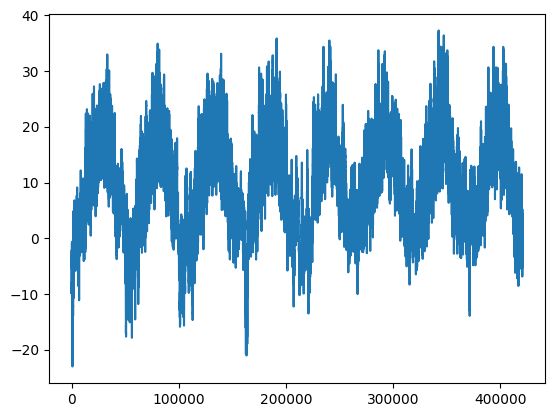

In [3]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] # температура (в градусах Цельсия)
plt.plot(range(len(temp)), temp)

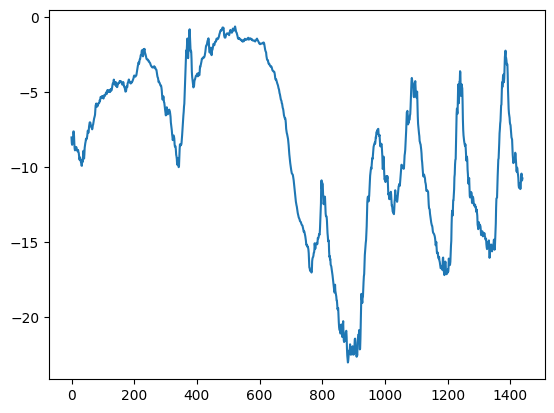

In [4]:
plt.plot(range(1440), temp[:1440])

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
                    shuffle=False, batch_size=128, step=6):
 if max_index is None:
    max_index = len(data) - delay - 1
 i = min_index + lookback
 while 1:
    if shuffle:
        rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
    else:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
    samples = np.zeros((len(rows),
        lookback // step,
        data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
        indices = range(rows[j] - lookback, rows[j], step)
        samples[j] = data[indices]
        targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=0,
 max_index=200000,
 shuffle=True,
 step=step,
 batch_size=batch_size)
val_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=200001,
 max_index=300000,
 step=step,
 batch_size=batch_size)
test_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=300001,
 max_index=None,
 step=step,
 batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) // batch_size 
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
def evaluate_naive_method():
 batch_maes = []
 for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
 print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


In [11]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.
shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)

Epoch 1/20


C:\Users\igorv\AppData\Local\Temp\ipykernel_53508\3391038488.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 13s 26ms/step - loss: 1.3966 - val_loss: 0.3995
Epoch 2/20
500/500 [==============================] - 12s 25ms/step - loss: 0.4111 - val_loss: 0.3034
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2879 - val_loss: 0.3067
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2670 - val_loss: 0.3369
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2538 - val_loss: 0.3054
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2432 - val_loss: 0.3187
Epoch 7/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2365 - val_loss: 0.3092
Epoch 8/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2284 - val_loss: 0.3103
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2250 - val_loss: 0.3275
Epoch 10/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2206 - val_los

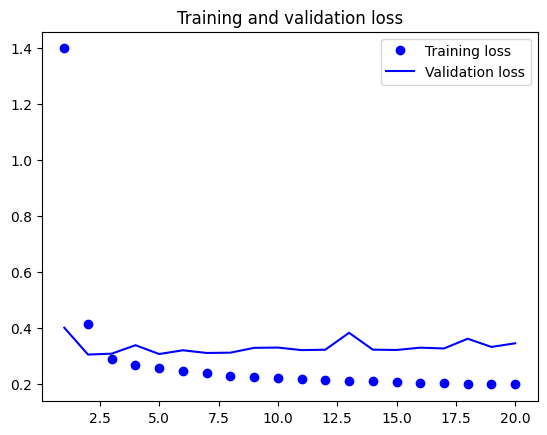

In [13]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)

Epoch 1/20


C:\Users\igorv\AppData\Local\Temp\ipykernel_53508\947630284.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 70s 136ms/step - loss: 0.3068 - val_loss: 0.2669
Epoch 2/20
500/500 [==============================] - 68s 136ms/step - loss: 0.2827 - val_loss: 0.2639
Epoch 3/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2774 - val_loss: 0.2621
Epoch 4/20
500/500 [==============================] - 61s 122ms/step - loss: 0.2709 - val_loss: 0.2634
Epoch 5/20
500/500 [==============================] - 63s 126ms/step - loss: 0.2655 - val_loss: 0.2637
Epoch 6/20
500/500 [==============================] - 63s 127ms/step - loss: 0.2604 - val_loss: 0.2635
Epoch 7/20
500/500 [==============================] - 66s 132ms/step - loss: 0.2551 - val_loss: 0.2674
Epoch 8/20
500/500 [==============================] - 63s 126ms/step - loss: 0.2502 - val_loss: 0.2723
Epoch 9/20
500/500 [==============================] - 62s 125ms/step - loss: 0.2461 - val_loss: 0.2729
Epoch 10/20
500/500 [==============================] - 62s 123ms/step - loss: 0.2415

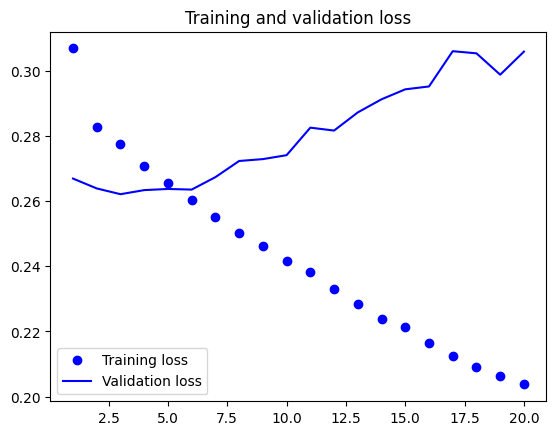

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
 dropout=0.2,
 recurrent_dropout=0.2,
 input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=40,
 validation_data=val_gen,
 validation_steps=val_steps)

Epoch 1/40


C:\Users\igorv\AppData\Local\Temp\ipykernel_53508\2684874413.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 101s 196ms/step - loss: 0.3281 - val_loss: 0.2814
Epoch 2/40
500/500 [==============================] - 96s 192ms/step - loss: 0.3060 - val_loss: 0.2753
Epoch 3/40
500/500 [==============================] - 98s 196ms/step - loss: 0.2976 - val_loss: 0.2784
Epoch 4/40
500/500 [==============================] - 96s 193ms/step - loss: 0.2930 - val_loss: 0.2706
Epoch 5/40
500/500 [==============================] - 96s 192ms/step - loss: 0.2895 - val_loss: 0.2708
Epoch 6/40
500/500 [==============================] - 97s 195ms/step - loss: 0.2857 - val_loss: 0.2722
Epoch 7/40
500/500 [==============================] - 97s 195ms/step - loss: 0.2818 - val_loss: 0.2690
Epoch 8/40
500/500 [==============================] - 98s 196ms/step - loss: 0.2772 - val_loss: 0.2673
Epoch 9/40
500/500 [==============================] - 104s 208ms/step - loss: 0.2747 - val_loss: 0.2696
Epoch 10/40
500/500 [==============================] - 106s 212ms/step - loss: 0.2

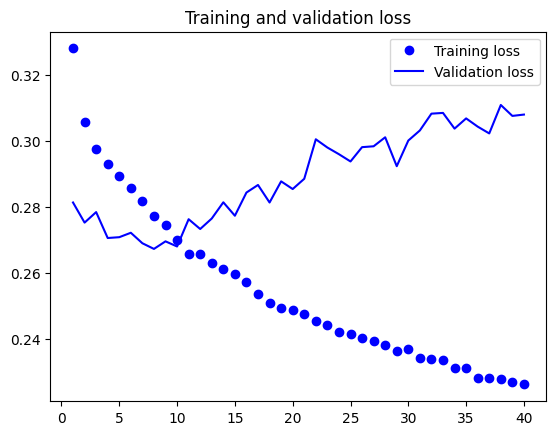

In [17]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
 dropout=0.1,
 recurrent_dropout=0.5,
 return_sequences=True,
 input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
 dropout=0.1,
 recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=40,
 validation_data=val_gen,
 validation_steps=val_steps)

Epoch 1/40


C:\Users\igorv\AppData\Local\Temp\ipykernel_53508\1695579533.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 255s 500ms/step - loss: 0.3196 - val_loss: 0.2772
Epoch 2/40
500/500 [==============================] - 199s 398ms/step - loss: 0.3032 - val_loss: 0.2766
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 0.2935

In [1]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras import layers
from keras.models import Sequential
max_features = 10000 
maxlen = 500 
(x_train, y_train), (x_test, y_test) = imdb.load_data(
 num_words=max_features) #Загрузка данных
x_train = [x[::-1] for x in x_train] 
x_test = [x[::-1] for x in x_test] #Обращение последовательностей
x_train = pad_sequences(x_train, maxlen=maxlen) 
x_test = pad_sequences(x_test, maxlen=maxlen)
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
 loss='binary_crossentropy',
 metrics=['acc'])
history = model.fit(x_train, y_train,
 epochs=10,
 batch_size=128,
 validation_split=0.2)

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
 epochs=10,
 batch_size=128,
 validation_split=0.2)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(
 layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=40,
 validation_data=val_gen,
 validation_steps=val_steps)

In [ ]:
from keras.datasets import imdb
from keras.utils import pad_sequences
max_features = 10000
max_len = 500
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=
 max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
 loss='binary_crossentropy',
 metrics=['acc'])
history = model.fit(x_train, y_train,
 epochs=10,
 batch_size=128,
 validation_split=0.2)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
 input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)

In [ ]:
step = 3 # Прежде имело значение 6 (один образец для каждого часа); теперь имеет значение 3 (один образец для каждых 30 минут)
lookback = 720
delay = 144 #Не изменились
train_gen = generator(float_data,lookback=lookback,delay=delay,
    min_index=0,max_index=200000,shuffle=True,step=step)
val_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=200001,
 max_index=300000,
 step=step)
test_gen = generator(float_data,
 lookback=lookback,
 delay=delay,
 min_index=300001,
 max_index=None,
 step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
 input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)